# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [11]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix
from IPython.display import clear_output, display, Math

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 0s 0us/step


In [5]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer1 = DenseLayer(
        num_features, n_hidden_1, name='hidden_layer1'
    )
    # Другий шар, який складається з 256 нейронів
    self.layer2 = DenseLayer(
        n_hidden_1, n_hidden_2, name='hidden_layer2'
    )
    # Вихідний шар
    self.out_layer = DenseLayer(
        n_hidden_2, num_classes, name='output_layer'
    )

  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer1(x, activation=0)
    x = self.layer2(x, activation=0)
    x = self.out_layer(x, activation=1)

    return x

In [6]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    predicted_class = tf.argmax(y_pred, axis=1)
    correct_prediction = (predicted_class == tf.cast(y_true, tf.int64))

    # Обчислюємо точність
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    return accuracy

In [9]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)
    # Отримаємо список оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables

    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [12]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі
steps = []

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss)
        accuracy_history.append(acc)
        steps.append(step)

        data_row = f'Step: {step:<4d} | Loss: {loss:>7.1f} | Accuracy: {acc:.2f}'

        clear_output(wait=True)
        print(data_row)
else:
    print("Тренування завершено.")

Step: 3000 | Loss:    48.1 | Accuracy: 0.93
Тренування завершено.


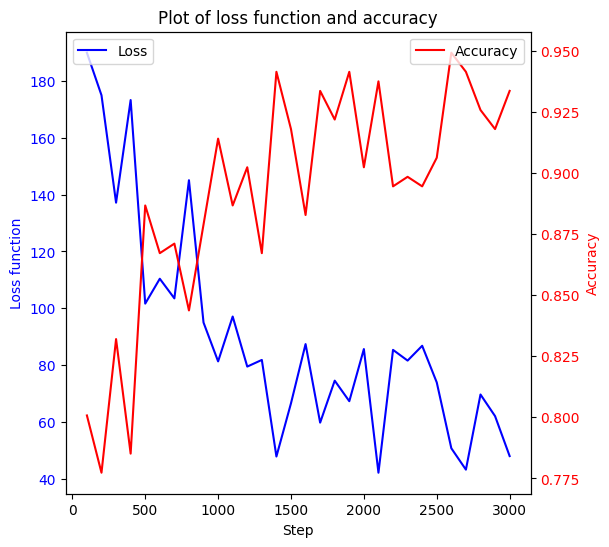

In [13]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись
fig, ax1 = plt.subplots(figsize=(6, 6))
ax2 = ax1.twinx()

# Виведіть графік функції втрат
ax1.plot(steps, loss_history, linestyle='-', color='b', label='Loss')
ax1.set_title('Plot of loss function and accuracy')
ax1.set_xlabel('Step')
ax1.set_ylabel('Loss function', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.legend(loc='upper left')

# Виведіть графік точності
ax2.plot(steps, accuracy_history, linestyle='-', color='r', label='Accuracy')
ax2.set_ylabel('Accuracy', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.legend(loc='upper right')

plt.show()

1. Тестова цифра: 9
2. Вектор передбачень:


<IPython.core.display.Math object>

3. Компонента з максимальним зхначенням:


<IPython.core.display.Math object>

4. Мережа передбачила цифру 9
5. Зображення цифри


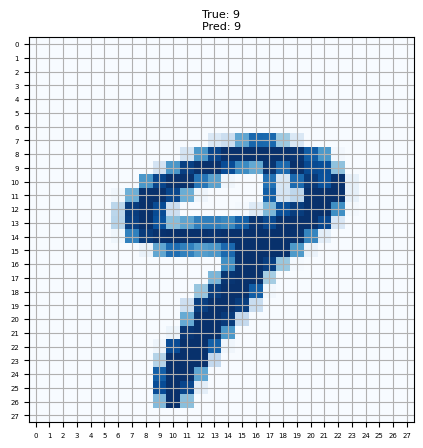

In [22]:
# Перевіримо нашу модель на якомусь одному зображенні

# Мета: попрактикуватись зайвий раз у визначенні розмірностей векторів вибірок

idx_of_some_digit = 9
test_image = x_test[idx_of_some_digit].reshape(1, -1)
test_digit = y_test[idx_of_some_digit]

print(f'1. Тестова цифра: {test_digit}')

# Прогнозуємо йовірності вибраних зображень
p_pred = neural_net(test_image)

# Виводимо індекс компоненти, яка має найбільше значення
y_pred = p_pred[0].numpy()
predicted_digit = y_pred.argmax()

# Виводимо компоненти вектора ймовірностей p_pred

print('2. Вектор передбачень:')

display(Math(
    fr'${{\vec y = ({" , ".join([f"p_{i}" for i in range(10)])})}} = ({", ".join([f"{digit_prob:.2f}" for digit_prob in y_pred])})$'))

print('3. Компонента з максимальним зхначенням:')

display(
    Math(fr'$p_{{{predicted_digit}}} = {p_pred[0].numpy()[predicted_digit]:.2f}$'))


print(f'4. Мережа передбачила цифру {predicted_digit}')

print(f'5. Зображення цифри')

plt.figure(figsize=(5, 5))
plt.xticks(range(0, 28, 1), fontsize=5)
plt.yticks(range(0, 28, 1), fontsize=5)
plt.imshow(test_image[0].reshape((28, 28)), cmap='Blues')
plt.title(f"True: {test_digit}\nPred: {predicted_digit}", fontsize=8)
plt.grid()
plt.show()

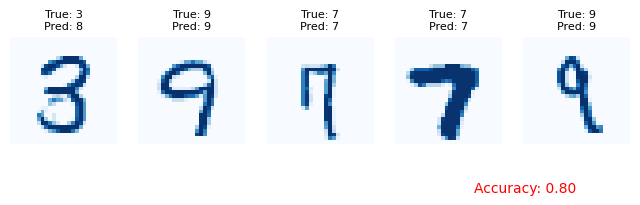

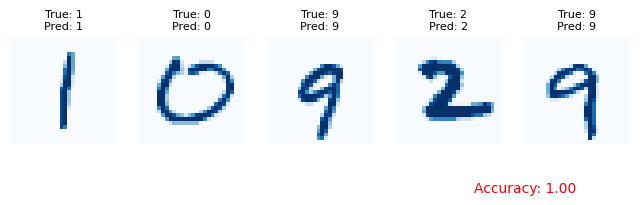

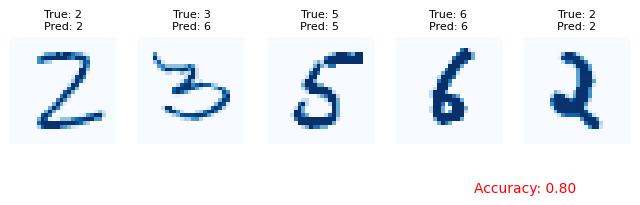

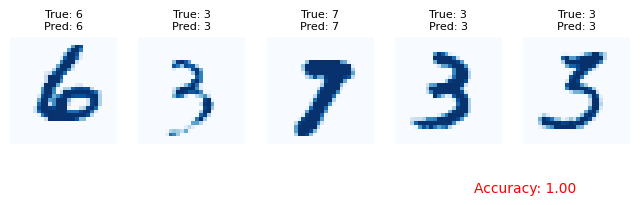

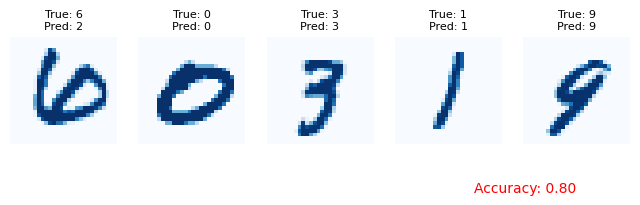

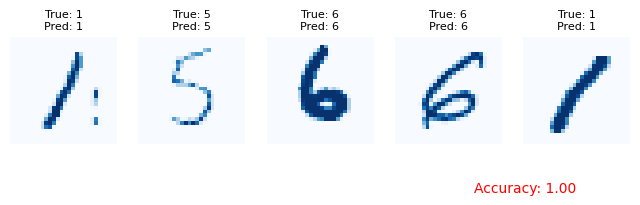

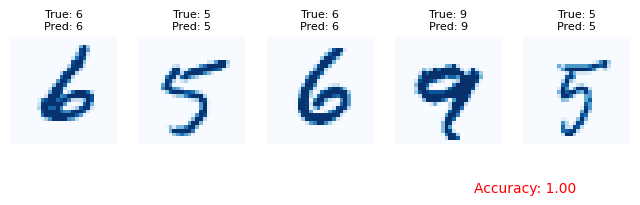

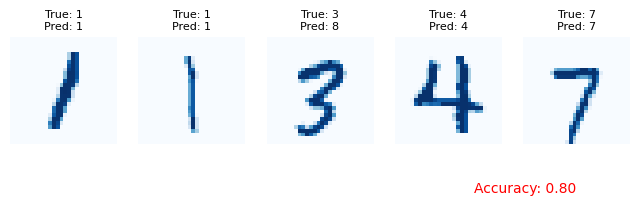

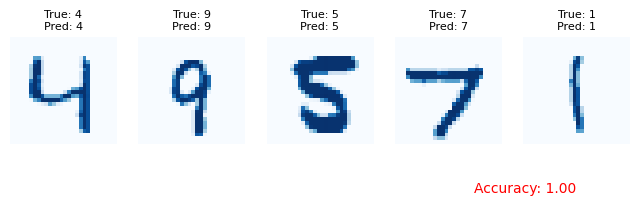

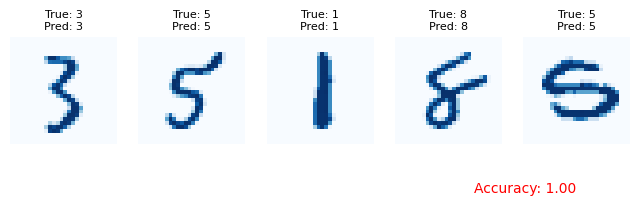

Загальна середня точність досліджень: 0.92


In [27]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.

# Виберемо 5 випадкових зображень з тестової вибірки
sample_size = 5
acc_list = []
for iteration in range(10):
    random_indices = np.random.choice(x_test.shape[0], sample_size)
    test_images = x_test[random_indices]
    test_digits = y_test[random_indices]

    # Прогнозуємо йовірності вибраних зображень
    p_pred = neural_net(test_images)

    # На основі ймовірностей прогнозуємо клас
    pred_digits = tf.argmax(p_pred, axis=1).numpy()

    # Виведемо зображення та випишемо поруч відповідь нейромережі
    plt.figure(figsize=(8, 4))
    for i in range(sample_size):
        plt.subplot(1, sample_size, i + 1)
        plt.imshow(test_images[i].reshape((28, 28)), cmap='Blues')
        plt.title(
            f"True: {test_digits[i]}\nPred: {pred_digits[i]}", fontsize=8)
        plt.axis('off')
    acc = np.mean(test_digits == pred_digits)
    acc_list.append(acc)
    plt.text(0, 40, f'Accuracy: {acc:.2f}', ha='center', c='r')
    plt.show()

# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?
acc = np.mean(acc_list)
print(f"Загальна середня точність досліджень: {acc:.2f}")

# Висновок:
## Нейронна мережа загалом визначає значення цифр вірно, з середньою точністю в районі 90%